# RNN을 활용한 자전거 대여량(시계열 데이터) 예측

### 밑의 사이트에서 만든 데이터로 RNN 학습

https://github.com/mikehzz/Python/tree/main/Machine%20learning/bike_sharing_demand

In [54]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import datetime
import calendar

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
path = "data/"
print(os.listdir("data/"))

['sampleSubmission.csv', 'test.csv', 'train.csv']


# load data

In [3]:
df_train = pd.read_csv(path + "train.csv", parse_dates = ['datetime'],
                         index_col='datetime', infer_datetime_format=True)
df_test = pd.read_csv(path + 'test.csv', parse_dates = ['datetime'],
                        index_col='datetime', infer_datetime_format=True)
df_submission = pd.read_csv(path+'sampleSubmission.csv', parse_dates = ['datetime'],
                        index_col='datetime', infer_datetime_format=True)

# Columns 

- datetime : 시간별 날짜
- season :  
  1.(1분기)  
  2.(2분기)   
  3.(3분기)  
  4.(4분기)
- holiday : 하루가 휴일로 간주되는지 여부
- workingday : 주말과 휴일이 아닌 일하는 날
- weather :   
  1.(맑음, 구름, 조금, 흐림)  
  2.(안개+흐림, 안개+구름, 안개+구름이 거의 없음 + 흐림)  
  3.(가벼운 눈, 가벼운 비 + 천둥 + 구름, 가벼운 비 + 구름)  
  4.(폭우 + 우박 + 천둥 + 안개, 눈 + 안개)
- temp : 섭씨 온도
- atemp : 섭씨 온도의 느낌
- humidity : 상대 습도
- windspeed : 풍속
- casual : 미등록 사용자 대여수
- registered : 등록된 사용자 대여수
- count : 대여수

 

In [4]:
df_train.head(3)

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,count
datetime,,,,,,,,,
2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81.0,0.0,16
2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80.0,0.0,40
2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80.0,0.0,32


In [5]:
df_test.head(3)

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed
datetime,,,,,,,,
2011-01-20 00:00:00,1,0,1,1,10.66,11.365,56,26.0027
2011-01-20 01:00:00,1,0,1,1,10.66,13.635,56,0.0000
2011-01-20 02:00:00,1,0,1,1,10.66,13.635,56,0.0000


In [6]:
df_submission.head(3)

,count
datetime,
2011-01-20 00:00:00,0
2011-01-20 01:00:00,0
2011-01-20 02:00:00,0


## datetime 에서 년,월,일,시간,분,초를 추출해 column 추가

In [7]:
df_train['year'] = df_train.index.year
df_train['month'] = df_train.index.month
df_train['day'] = df_train.index.day
df_train['hour'] = df_train.index.hour
df_train['minute'] = df_train.index.minute
df_train['second'] = df_train.index.second

In [8]:
df_test['year'] = df_test.index.year
df_test['month'] = df_test.index.month
df_test['day'] = df_test.index.day
df_test['hour'] = df_test.index.hour
df_test['minute'] = df_test.index.minute
df_test['second'] = df_test.index.second

In [9]:
df_test.head()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,year,month,day,hour,minute,second
datetime,,,,,,,,,,,,,,
2011-01-20 00:00:00,1,0,1,1,10.66,11.365,56,26.0027,2011,1,20,0,0,0
2011-01-20 01:00:00,1,0,1,1,10.66,13.635,56,0.0000,2011,1,20,1,0,0
2011-01-20 02:00:00,1,0,1,1,10.66,13.635,56,0.0000,2011,1,20,2,0,0
2011-01-20 03:00:00,1,0,1,1,10.66,12.880,56,11.0014,2011,1,20,3,0,0
2011-01-20 04:00:00,1,0,1,1,10.66,12.880,56,11.0014,2011,1,20,4,0,0


## 연도별, 월별,시간별에 따른 대여량 평균치 분석

In [10]:
def bar_plot(df, x, ax):
    fig = plt.figure(figsize=(5,3))
    sns.barplot(data=df, x=x, y="count", palette="Blues_d", ax=ax)

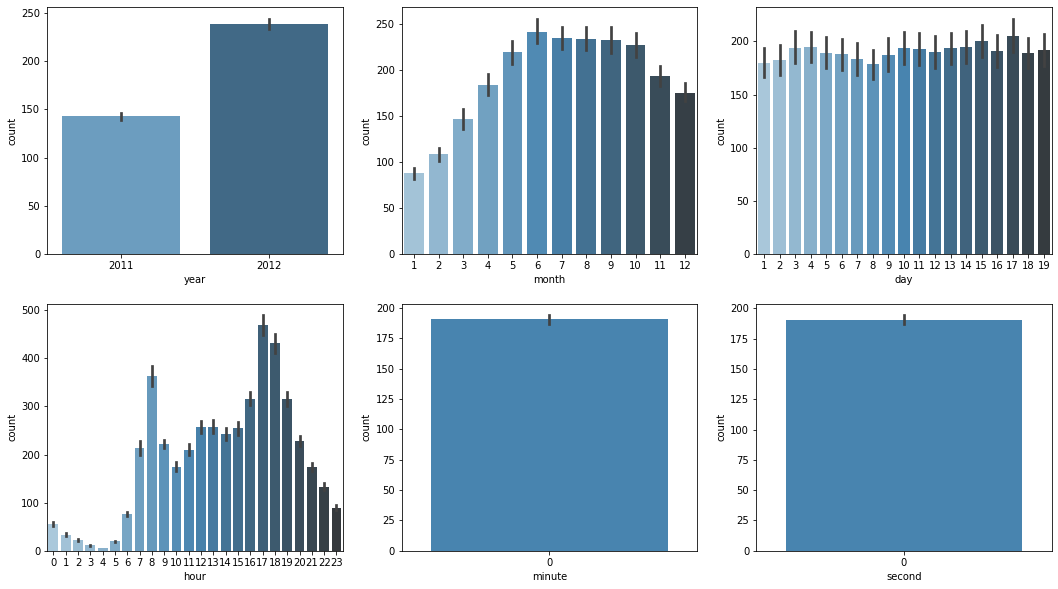

<Figure size 360x216 with 0 Axes>

<Figure size 360x216 with 0 Axes>

<Figure size 360x216 with 0 Axes>

<Figure size 360x216 with 0 Axes>

<Figure size 360x216 with 0 Axes>

<Figure size 360x216 with 0 Axes>

In [11]:
figure, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(nrows=2, ncols=3)
figure.set_size_inches(18, 10)

bar_plot(df_train, "year", ax=ax1)
bar_plot(df_train, "month", ax=ax2)
bar_plot(df_train, "day", ax=ax3)
bar_plot(df_train, "hour", ax=ax4)
bar_plot(df_train, "minute", ax=ax5)
bar_plot(df_train, "second", ax=ax6)

## 연도별,월별,시간별에 따른 분석 결과

- 연도별 : 2011년보다 2012년 대여량이 많아짐  
- 월별 : 월별 대여량은 6월에 가장 많고, 따뜻한 계절(5~10월달)에 대여량이 많음
- 일별 : 일별 대여량은 크게 차이점이 없고, 특징점 역시 없음.
- 시간별 : 오전에는 8시에 가장 많고, 오후에는 17시~18시에 가장 많음

### count에 영향을 주는 time feature는 year, month, hour이고, 나머지는 크게 영향을 안받음. 

## 시간대별 자전거 대여량 (근무일 유무, 요일, 시즌, 날씨)

In [12]:
def point_plot(df, hue, ax):
    sns.pointplot(data=df, x="hour", y="count", ax=ax, hue=hue)

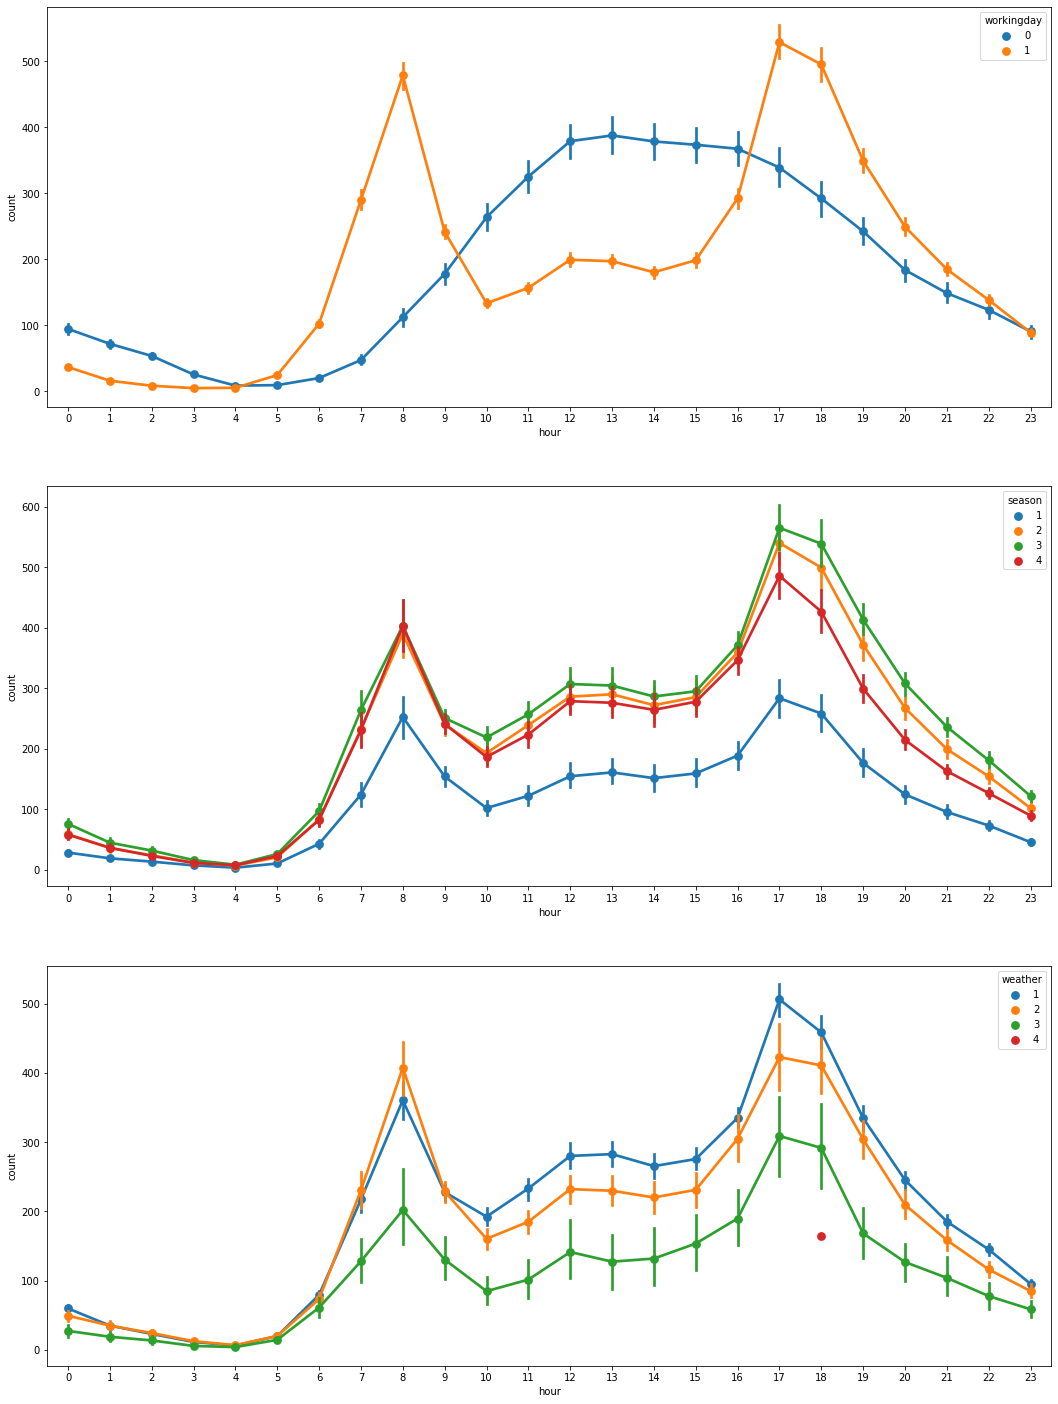

In [13]:
fig,(ax1, ax2, ax3)= plt.subplots(nrows=3)
fig.set_size_inches(18,25)

#sns.pointplot(df_train, ax=ax1)
point_plot(df_train, 'workingday', ax=ax1)
point_plot(df_train, 'season', ax=ax2)
point_plot(df_train, 'weather', ax=ax3)

앞선 시간대별 자전거 대여량 그래프를 보면 오전8시, 오후 5~6시에 가장 대여량이 많았다.

근무일, 요일, 분기, 날씨에 따른 대여량에 대한 분석  
- 근무일에는 출근시간(8시), 퇴근시간(17 ~ 18시)에 가장 대여량이 높았고, 휴무일에는 12 ~ 16시에 가장 대여를 많이했다.
- 평일은 근무일 대여량, 주말은 휴무일 대여량에 따르는 것을 확인할 수 있다.
- 3분기(7 ~ 9월)에 가장 대여를 많이하고, 1분기(1 ~ 3월)에 가장 적게 대여를 하는 것을 볼 수 있다.
- 날씨가 좋을 수록 대여를 많이하고, 좋지 않을 때는 대여를 많이 안한다.

# scaler

StandardScaler는 평균값과 표준편차로 계산하기 때문에 이상치가 있는지 확인해줘야 함.

In [14]:
from sklearn.preprocessing import StandardScaler

In [15]:
def dist_plot(x, ax):
    sns.distplot(x=x, ax=ax)

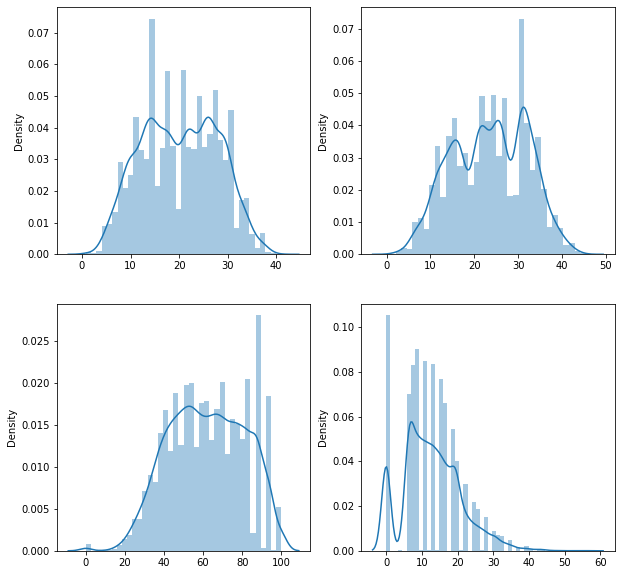

In [16]:
fig,((ax1, ax2),(ax3, ax4))= plt.subplots(nrows=2, ncols=2)
fig.set_size_inches(10,10)

dist_plot(df_train["temp"], ax=ax1)
dist_plot(df_train["atemp"], ax=ax2)
dist_plot(df_train["humidity"], ax=ax3)
dist_plot(df_train["windspeed"], ax=ax4)

### temp, atemp,humidity,windspeed scaler

In [17]:
columns_to_scale = ['temp','atemp','humidity','windspeed']
train_temp_hum_wind_transformer = StandardScaler().fit(df_train[columns_to_scale].to_numpy())
test_temp_hum_wind_transformer = StandardScaler().fit(df_test[columns_to_scale].to_numpy())

columns_to_scale_2 = ["count"]
count_transformer = StandardScaler().fit(df_train[columns_to_scale_2])

df_train.loc[:,columns_to_scale] = train_temp_hum_wind_transformer.transform(df_train[columns_to_scale].to_numpy())
df_test.loc[:,columns_to_scale] = test_temp_hum_wind_transformer.transform(df_test[columns_to_scale].to_numpy())

df_train["count"] = count_transformer.transform(df_train[columns_to_scale_2])

### time feature scaler

### year이 2011 -> 0, 2012 -> 1

In [18]:
def scaler_year(year):
    if year in [2011]:
        return 0
    elif year in [2012]:
        return 1
    
df_train['year'] = df_train["year"].apply(scaler_year)

In [19]:
def scaler_year(year):
    if year in [2011]:
        return 0
    elif year in [2012]:
        return 1

df_test['year'] = df_test["year"].apply(scaler_year)

### month scaler

<AxesSubplot:xlabel='month', ylabel='count'>

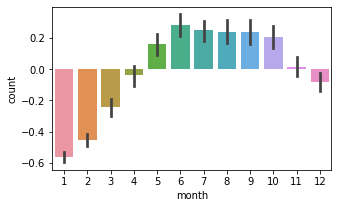

In [20]:
fig = plt.figure(figsize=(5,3))
sns.barplot(data=df_train, x="month", y="count")

In [21]:
def scaler_month(month):
    if month in [1,2,3]:
        return 0
    elif month in [4,11,12]:
        return 1
    elif month in [5]:
        return 2
    elif month in [6,7,8,9,10]:
        return 3
df_train['month_group'] = df_train["month"].apply(scaler_month)

In [22]:
def scaler_month(month):
    if month in [1,2,3]:
        return 0
    elif month in [4,11,12]:
        return 1
    elif month in [5]:
        return 2
    elif month in [6,7,8,9,10]:
        return 3
df_test['month_group'] = df_test["month"].apply(scaler_month)

### hour scaler

<AxesSubplot:xlabel='hour', ylabel='count'>

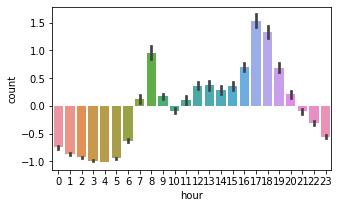

In [23]:
fig = plt.figure(figsize=(5,3))
sns.barplot(data=df_train, x="hour", y="count")

In [24]:
def scaler_hour(hour):
    if hour in [0,1,2,3,4,5,6,22,23]:
        return 0
    elif hour in [7,9,10,11,20,21]:
        return 1
    elif hour in [8,17,18]:
        return 4
    elif hour in [6,7,8,9,10]:
        return 3
    else:
        return 2
df_train['hour_group'] = df_train["hour"].apply(scaler_hour)

In [25]:
def scaler_hour(hour):
    if hour in [0,1,2,3,4,5,6,22,23]:
        return 0
    elif hour in [7,9,10,11,20,21]:
        return 1
    elif hour in [8,17,18]:
        return 4
    elif hour in [6,7,8,9,10]:
        return 3
    else:
        return 2
df_test['hour_group'] = df_test["hour"].apply(scaler_hour)

### drop features : month, day, hour, minute, second 

In [26]:
drop_features = ["month","day","hour","minute","second"]

df_train = df_train.drop(drop_features, axis=1)
df_test = df_test.drop(drop_features, axis=1)

In [27]:
df_train.head(3)

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,count,year,month_group,hour_group
datetime,,,,,,,,,,,,
2011-01-01 00:00:00,1,0,0,1,-1.322793,-1.081736,0.989740,-1.569205,-0.964093,0,0,0
2011-01-01 01:00:00,1,0,0,1,-1.427728,-1.171110,0.937835,-1.569205,-0.831593,0,0,0
2011-01-01 02:00:00,1,0,0,1,-1.427728,-1.171110,0.937835,-1.569205,-0.875760,0,0,0


In [28]:
training_set_size = int(len(df_train)*0.9)
test_set_size = len(df_train)-training_set_size
train_data,test_data = df_train.iloc[0:training_set_size],df_train.iloc[training_set_size:len(df_train)]
print("Length of training set is", len(train_data))    
print("Length of test set is",len(test_data))

Length of training set is 9849
Length of test set is 1095


In [29]:
def create_data_sequence(X, y, time_steps=1):
    """ Create data sequence
    
    Arguments:
        * X: time-series data
        * y: Count "cnt" value
        * time_steps: Used to create input sequence of timesteps
    
    Returns:
        * input_sequence: Numpy array of sequences of time-series data
        * output: Numpy array of output i.e. next value for respective sequence
    
    """
    input_sequence, target = [], []
    for i in range(len(X) - time_steps):
        sequence = X.iloc[i:(i + time_steps),[0,1,2,3,4,5,6,7,9,10,11]].values
        input_sequence.append(sequence)        
        target.append(y.iloc[i + time_steps])
    return np.array(input_sequence), np.array(target)

In [30]:
time_steps = 24

# Here training_set_sequence, test_set_sequence are input features for training and test set, as numpy arrays. 
# training_set_output and test_set_output are "cnt" values for training and test set sequences, as numpy arrays.
X_train, y_train = create_data_sequence(train_data, train_data["count"], time_steps)
X_test, y_test = create_data_sequence(test_data, test_data["count"], time_steps)

# We get training and test set sequences as [samples, time_steps, n_features]

print("Training data shape", X_train.shape, "Training data output shape", y_train.shape)
print("Test data shape", X_test.shape, "Test data output shape", y_test.shape)

Training data shape (9825, 24, 11) Training data output shape (9825,)
Test data shape (1071, 24, 11) Test data output shape (1071,)


# RNN

In [31]:
from tensorflow import keras
from tensorflow.keras import datasets, layers, models, Sequential

## Simple RNN 

In [40]:
n_steps = X_train.shape[1]
n_features = X_train.shape[2]
model = Sequential()
model.add(keras.layers.SimpleRNN(32, return_sequences=True, input_shape=(n_steps, n_features), dropout=0.0, recurrent_dropout=0.2,))
model.add(keras.layers.SimpleRNN(32, return_sequences=True, input_shape=(n_steps, n_features)))
#model.add(SimpleRNN(164, return_sequences=True, input_shape=(n_steps, n_features)))
model.add(keras.layers.SimpleRNN(16))
model.add(keras.layers.Dense(1))

# define optimizer and compile model
model.compile(optimizer="adam", loss='mse', metrics = ['mse'])

# fit model
history = model.fit(X_train, y_train,
                    validation_split=0.1,
                    epochs=50, verbose=1)

Epoch 1/50
277/277 [==============================] - 25s 86ms/step - loss: 0.5227 - mse: 0.5227 - val_loss: 0.8513 - val_mse: 0.8513
Epoch 2/50
277/277 [==============================] - 23s 85ms/step - loss: 0.3252 - mse: 0.3252 - val_loss: 0.5360 - val_mse: 0.5360
Epoch 3/50
277/277 [==============================] - 23s 83ms/step - loss: 0.2128 - mse: 0.2128 - val_loss: 0.3690 - val_mse: 0.3690
Epoch 4/50
277/277 [==============================] - 24s 87ms/step - loss: 0.1556 - mse: 0.1556 - val_loss: 0.3164 - val_mse: 0.3164
Epoch 5/50
277/277 [==============================] - 24s 85ms/step - loss: 0.1205 - mse: 0.1205 - val_loss: 0.2222 - val_mse: 0.2222
Epoch 6/50
277/277 [==============================] - 24s 85ms/step - loss: 0.1034 - mse: 0.1034 - val_loss: 0.2527 - val_mse: 0.2527
Epoch 7/50
277/277 [==============================] - 23s 82ms/step - loss: 0.0980 - mse: 0.0980 - val_loss: 0.2079 - val_mse: 0.2079
Epoch 8/50
277/277 [==============================] - 22s 79ms

In [43]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_6 (SimpleRNN)    (None, 24, 32)            1408      
                                                                 
 simple_rnn_7 (SimpleRNN)    (None, 24, 32)            2080      
                                                                 
 simple_rnn_8 (SimpleRNN)    (None, 16)                784       
                                                                 
 dense_2 (Dense)             (None, 1)                 17        
                                                                 
Total params: 4,289
Trainable params: 4,289
Non-trainable params: 0
_________________________________________________________________


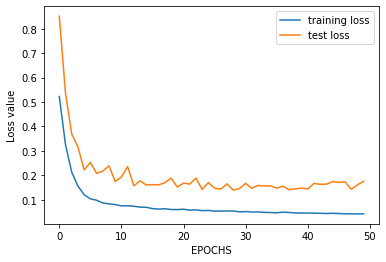

In [42]:
fig,ax = plt.subplots()
plt.plot(history.history['loss'], label='training loss')
plt.plot(history.history['val_loss'], label='test loss')
ax.set_xlabel('EPOCHS')
ax.set_ylabel('Loss value')
plt.legend()

In [44]:
test_set_predictions = model.predict(X_test)

## 실제 값과 예측값 비교

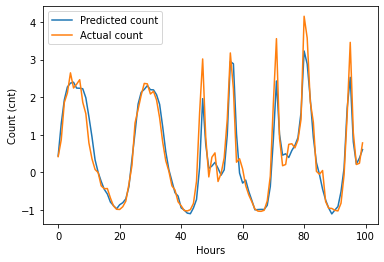

In [45]:
fig,ax = plt.subplots()
plt.plot(test_set_predictions[:100,], label='Predicted count')
plt.plot(y_test[:100,], label='Actual count')
ax.set_xlabel('Hours')
ax.set_ylabel('Count (cnt)')
plt.legend();
plt.show()

## LSTM

In [46]:
n_steps = X_train.shape[1]
n_features = X_train.shape[2]
model = Sequential()
model.add(keras.layers.LSTM(32, return_sequences=True, input_shape=(n_steps, n_features), dropout=0.0, recurrent_dropout=0.2,))
#model.add(keras.layers.LSTM(32, return_sequences=True, input_shape=(n_steps, n_features)))
#model.add(keras.layers.LSTM(164, return_sequences=True, input_shape=(n_steps, n_features)))
model.add(keras.layers.LSTM(16))
model.add(keras.layers.Dense(1))

# define optimizer and compile model
model.compile(optimizer="adam", loss='mse', metrics = ['mse'])

# fit model
history = model.fit(X_train, y_train,
                    validation_split=0.1,
                    epochs=10, verbose=1)

Epoch 1/10
277/277 [==============================] - 36s 120ms/step - loss: 0.4201 - mse: 0.4201 - val_loss: 0.6254 - val_mse: 0.6254
Epoch 2/10
277/277 [==============================] - 33s 118ms/step - loss: 0.2051 - mse: 0.2051 - val_loss: 0.3496 - val_mse: 0.3496
Epoch 3/10
277/277 [==============================] - 33s 119ms/step - loss: 0.1274 - mse: 0.1274 - val_loss: 0.3430 - val_mse: 0.3430
Epoch 4/10
277/277 [==============================] - 33s 118ms/step - loss: 0.1043 - mse: 0.1043 - val_loss: 0.2542 - val_mse: 0.2542
Epoch 5/10
277/277 [==============================] - 33s 120ms/step - loss: 0.0858 - mse: 0.0858 - val_loss: 0.2059 - val_mse: 0.2059
Epoch 6/10
277/277 [==============================] - 33s 121ms/step - loss: 0.0767 - mse: 0.0767 - val_loss: 0.1955 - val_mse: 0.1955
Epoch 7/10
277/277 [==============================] - 33s 120ms/step - loss: 0.0721 - mse: 0.0721 - val_loss: 0.2230 - val_mse: 0.2230
Epoch 8/10
277/277 [==============================] - 3

In [47]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 24, 32)            5632      
                                                                 
 lstm_1 (LSTM)               (None, 16)                3136      
                                                                 
 dense_3 (Dense)             (None, 1)                 17        
                                                                 
Total params: 8,785
Trainable params: 8,785
Non-trainable params: 0
_________________________________________________________________


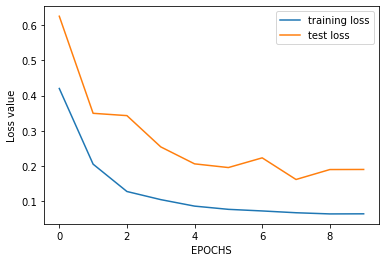

In [48]:
fig,ax = plt.subplots()
plt.plot(history.history['loss'], label='training loss')
plt.plot(history.history['val_loss'], label='test loss')
ax.set_xlabel('EPOCHS')
ax.set_ylabel('Loss value')
plt.legend()

In [49]:
test_set_predictions = model.predict(X_test)

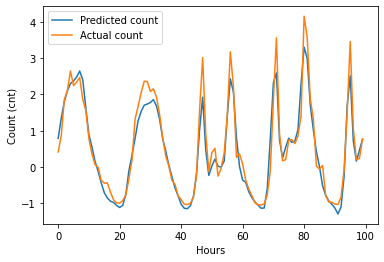

In [50]:
fig,ax = plt.subplots()
plt.plot(test_set_predictions[:100,], label='Predicted count')
plt.plot(y_test[:100,], label='Actual count')
ax.set_xlabel('Hours')
ax.set_ylabel('Count (cnt)')
plt.legend();
plt.show()